In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro")

In [8]:
from langchain_core.tools import tool 
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# Replace 'YOUR_APP_ID' with your actual Wolfram Alpha API key
app_id = 'KWW3UE-KE799U2QKY'

@tool 
def graph_plot(query: str) -> str:
    '''
    function for plotting the graph for the given mathematical function or equation, in text format. Takes a single expression at a time.

    Args:
        query: str - the query of mathematical function or equation, which needs to plotted.
    Returns:
        str - whether the plot is successfully plotted or not.
    '''
# URL for the Wolfram Alpha API
    url = f'http://api.wolframalpha.com/v2/query?input={query}&format=image,plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    try:
        # Extract the image URL from the response
        pods = data['queryresult']['pods']
        image_url = None
        for pod in pods:
            if 'plot' in pod['title'].lower():
                subpods = pod['subpods']
                for subpod in subpods:
                    if 'img' in subpod:
                        image_url = subpod['img']['src']
                        break
                if image_url:
                    break
        
        # Check if an image URL was found
        print(image_url)
        if image_url:
            # Download the image
            image_response = requests.get(image_url)
            img = Image.open(BytesIO(image_response.content))

            # Display the image using Matplotlib
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            return "Plot succesfully plotted"
        else:
            return "No plot found in the query result."
    except Exception as e:
        print(e)
        return "No plot found"

@tool
def show_steps(query: str) -> str:
    '''
    function for solving a mathematical expression or equation, and providing each steps for the solution.

    Args:
        query: str - the mathematical query, in the form of expression or equation which needs to be solved.
    
    Returns:
        str - solution with complete steps of solution
    '''
    url = f'http://api.wolframalpha.com/v2/query?input={query}&podstate=Result__Step-by-step+solution&format=plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    # Extract the solution steps from the response
    message = ""
    steps = []
    pods = data['queryresult']['pods']
    for pod in pods:
        if 'Solution' in pod['title'] or 'Result' in pod['title']:
            subpods = pod['subpods']
            for subpod in subpods:
                if 'plaintext' in subpod:
                    steps.append(subpod['plaintext'])

    # Check if solution steps were found
    if steps:
        message += "Solution Steps:\n"
        for step in steps:
            message += step + "\n"
    else:
        message += "No solution steps found in the query result."
    
    return message


In [9]:
tool_list = [graph_plot, show_steps]

model_with_tools = llm.bind_tools(tool_list)

In [11]:
from langchain_core.messages import HumanMessage

response = model_with_tools.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")])

print(f"Content String: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

Content String: 
ToolCalls: [{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}]


In [15]:
print(llm.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")]).content)

Given equations:
4x - 3y = 2
2y + 3x = 7

To solve this system of linear equations, we can use the substitution method.

1. Solve the first equation for x:
4x - 3y = 2
4x = 3y + 2
x = (3y + 2)/4

2. Substitute the expression for x from step 1 into the second equation:
2y + 3x = 7
2y + 3((3y + 2)/4) = 7
2y + (9y + 6)/4 = 7

3. Simplify and solve for y:
2y + (9y + 6)/4 = 7
8y + 9y + 6 = 28
17y = 22
y = 22/17

4. Substitute the value of y back into the expression for x from step 1:
x = (3y + 2)/4
x = (3(22/17) + 2)/4
x = (66/17 + 2)/4
x = 11/17

So, the solution to the system of equations is:
x = 11/17
y = 22/17


In [13]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'show_steps', 'arguments': '{"query": "4x - 3y = 2\\\\n2y + 3x = 7"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3534f533-17f2-4a06-b978-4c4620703d5e-0', tool_calls=[{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}])

In [43]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

prompt_1 = ChatPromptTemplate.from_template(
    """
Given the mathematical query, write the best set of equations, expressions or functions 
which can be plotted or shown in the graph which are relevant to the solution or procedure of the 
original query. Include some guidelines to guide the plot or graph making process to showcase solution.

Query: {query}
"""
)

In [44]:
chain_1 = LLMChain(llm=llm, prompt=prompt_1)

In [45]:
resp = chain_1.run("4x - 3y = 2, and 2y + 3x = 7")

In [46]:
prompt_2 = ChatPromptTemplate.from_template(
    """
Based on the given guidelines, write Python code for plotting the graph. You 
can use libraries - matplotlib, seaborn, pandas or numpy. (not necessary to use all). 
If there is an intersection or solution point/s, be extra careful to calculate the point/s 
and use the expressions, equations or functions to calculate these point/s.

Guideline: {guideline}
"""
)

chain_2 = LLMChain(llm=llm, prompt=prompt_2)

In [47]:
from langchain.chains import SimpleSequentialChain

simple_chain = SimpleSequentialChain(
    chains=[chain_1, chain_2], 
    verbose=True
)

In [48]:
response = simple_chain.run("4x - 3y = 2, and 2y + 3x = 7")



> Entering new SimpleSequentialChain chain...


**Equation 1:** 4x - 3y = 2
**Equation 2:** 2y + 3x = 7

**Guidelines for Graphing:**

1. **Solve for y in both equations:**
    - From Eq. 1: y = (4x - 2) / 3
    - From Eq. 2: y = (7 - 3x) / 2

2. **Plot the two lines:**
    - Plot the line y = (4x - 2) / 3 as a dashed line.
    - Plot the line y = (7 - 3x) / 2 as a solid line.

3. **Mark the intersection point:**
    - The intersection point is where the two lines cross.
    - To find the coordinates, solve the system of equations simultaneously.

4. **Shade the solution region:**
    - The solution region is the area where both equations are satisfied.
    - Shade the region below the dashed line and above the solid line.
```python
import numpy as np
import matplotlib.pyplot as plt

# Define the two equations
eq1 = lambda x: (4*x - 2) / 3
eq2 = lambda x: (7 - 3*x) / 2

# Plot the two lines
x = np.linspace(-10, 10, 100)
plt.plot(x, eq1(x), '--', label='Equation 1')
plt.plot(x, eq2(x), '-', label='Equation 2')

# Find the intersectio

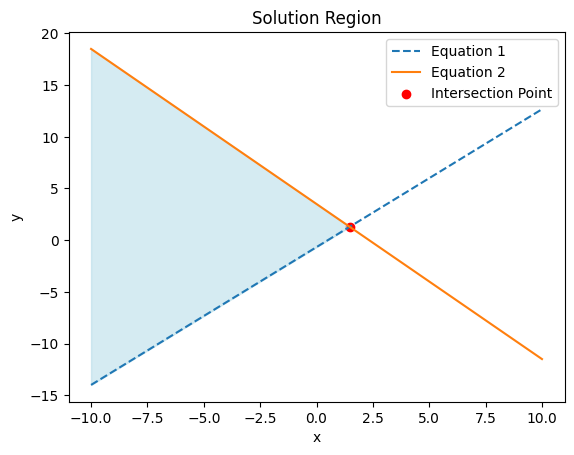

In [49]:
exec(response.replace("`", "").replace("python", ""))

In [38]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

prompt_1 = ChatPromptTemplate.from_template(
    """
Given the mathematical query, write the approach to solve the query, and some broad steps for 
the solution. Describe the approach briefly and add some guidelines for solution if required. 

Query: {query}
"""
)
chain_1 = LLMChain(llm=llm, prompt=prompt_1)

In [39]:
prompt_2 = ChatPromptTemplate.from_template(
    """
Based on the given guidelines, solve the each step of mathematical expression or function 
with detailed explaination of the solution. Explain the solution also in context of the given 
mathematical query.

Steps: {guideline}
"""
)

chain_2 = LLMChain(llm=llm, prompt=prompt_2)

In [40]:
from langchain.chains import SimpleSequentialChain

simple_chain = SimpleSequentialChain(
    chains=[chain_1, chain_2], 
    verbose=True
)

In [41]:
response = simple_chain.run("4x - 3y = 2, and 2y + 3x = 7")



> Entering new SimpleSequentialChain chain...
**Approach:**

Use the substitution method to solve for x and y.

**Steps:**

1. Solve one equation for one variable (e.g., solve the first equation for y: y = (4x - 2)/3).
2. Substitute the expression for the variable into the other equation and solve for the remaining variable (e.g., substitute y = (4x - 2)/3 into the second equation and solve for x).
3. Substitute the value of the variable found in step 2 back into one of the original equations to solve for the other variable (e.g., substitute x = 1 into the first equation to solve for y).

**Guidelines:**

* Ensure that the equations are in the form ax + by = c, where a, b, and c are constants.
* Choose the equation that is easier to solve for one of the variables.
* When substituting, be careful to replace all instances of the variable with the expression derived in step 1.
* Check your solution by plugging the values of x and y back into both original equations.
**Step 1: Solve one 

In [42]:
print(response)

**Step 1: Solve one equation for one variable.**

In this case, we can solve the first equation for y:

```
y = (4x - 2)/3
```

**Step 2: Substitute the expression for the variable into the other equation and solve for the remaining variable.**

Substituting the expression for y into the second equation, we get:

```
3x + (4x - 2)/3 = 10
```

Multiplying both sides by 3 to clear the fraction, we get:

```
9x + 4x - 2 = 30
```

Combining like terms, we get:

```
13x = 32
```

Dividing both sides by 13, we get:

```
x = 32/13
```

**Step 3: Substitute the value of the variable found in step 2 back into one of the original equations to solve for the other variable.**

Substituting x = 32/13 into the first equation, we get:

```
y = (4(32/13) - 2)/3
```

Simplifying, we get:

```
y = (128/13 - 2)/3
```

```
y = (128/13 - 26/13)/3
```

```
y = 102/39
```

**Therefore, the solution to the system of equations is x = 32/13 and y = 102/39.**

**Checking the solution:**

Plugging x = 32/13 and y